# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

     |████████████████████████████████| 78 kB 4.2 MB/s 
     |████████████████████████████████| 462 kB 26.5 MB/s 
  Created wheel for adapt: filename=adapt-0.4.0-py3-none-any.whl size=101264 sha256=82f3167761ba64ddd4f906850e4c135afbc22209af0729cf15a05d96854d90cc
  Stored in directory: /root/.cache/pip/wheels/47/47/61/e923985c37a7075ec75c4b16295782354b1c5dd291d47a7637
Successfully built adapt


In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_256_3200_train3.pkl"


Target_dir_train1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train1.pkl")
Target_dir_train2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_train2.pkl")
Target_dir_test1 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test1.pkl")
Target_dir_test2 = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_256_3200_test2.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train1.pkl")
Target_cyclegan_dir_train2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_train2.pkl")
Target_cyclegan_dir_test1 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test1.pkl")
Target_cyclegan_dir_test2 = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_256_3200_test2.pkl")

In [ ]:
BATCH_SIZE = 8
CHANNELS = 3
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256

# Loading Dataset

## LC25000 Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] 
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label']))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)

In [ ]:
LC25000_train_data = np.array(LC25000_train_data, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", np.shape(LC25000_train_data))
print("The shape of LC25000_train_labels: ", np.shape(LC25000_train_labels))

The shape of LC25000_train_data:  (3200, 256, 256, 3)
The shape of LC25000_train_labels:  (3200,)


In [ ]:
import gc
gc.collect()

272

## TCGA Cyclegan Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_cyclegan_dir_train1), "rb") as f:
    TCGA_cyclegan_train1 = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_train2), "rb") as f:
    TCGA_cyclegan_train2 = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_test1), "rb") as f:
    TCGA_cyclegan_test1 = pickle.load(f)
with open(os.path.abspath(Target_cyclegan_dir_test2), "rb") as f:
    TCGA_cyclegan_test2 = pickle.load(f)

In [ ]:
TCGA_cyclegan_train_data = TCGA_cyclegan_train1['train'] + TCGA_cyclegan_train2['train']
TCGA_cyclegan_train_labels = np.concatenate((TCGA_cyclegan_train1['train_label'],TCGA_cyclegan_train2['train_label']))
TCGA_cyclegan_test_data = TCGA_cyclegan_test1['test'] + TCGA_cyclegan_test2['test']
TCGA_cyclegan_test_labels = np.concatenate((TCGA_cyclegan_test1['test_label'],TCGA_cyclegan_test2['test_label']))

In [ ]:
TCGA_cyclegan_train_lab = tf.one_hot(TCGA_cyclegan_train_labels, depth=3)
TCGA_cyclegan_test_lab = tf.one_hot(TCGA_cyclegan_test_labels, depth=3)

In [ ]:
TCGA_cyclegan_train_data = np.array(TCGA_cyclegan_train_data, dtype=np.float32)
TCGA_cyclegan_test_data = np.array(TCGA_cyclegan_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_cyclegan_train_data: ", TCGA_cyclegan_train_data.shape)
print("The shape of TCGA_cyclegan_train_labels: ", TCGA_cyclegan_train_labels.shape)
print("The shape of TCGA_cyclegan_test_data: ", TCGA_cyclegan_test_data.shape)
print("The shape of TCGA_cyclegan_test_labels: " , TCGA_cyclegan_test_labels.shape)

The shape of TCGA_cyclegan_train_data:  (3200, 256, 256, 3)
The shape of TCGA_cyclegan_train_labels:  (3200,)
The shape of TCGA_cyclegan_test_data:  (3200, 256, 256, 3)
The shape of TCGA_cyclegan_test_labels:  (3200,)


In [ ]:
import gc
gc.collect()

1107

## Datasets Visualization

<function matplotlib.pyplot.show>

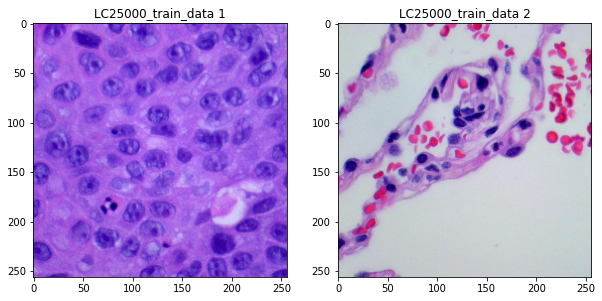

In [ ]:
# random show source images
fig = plt.subplots(1,2,figsize=(10,10))
#plt.suptitle("Source Domain = LC25000", fontsize=18)
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_train_data)
img1 = array_to_img(sample1)
plt.show
plt.title("LC25000_train_data 1")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_train_data)
img2 = array_to_img(sample2)
plt.title("LC25000_train_data 2")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

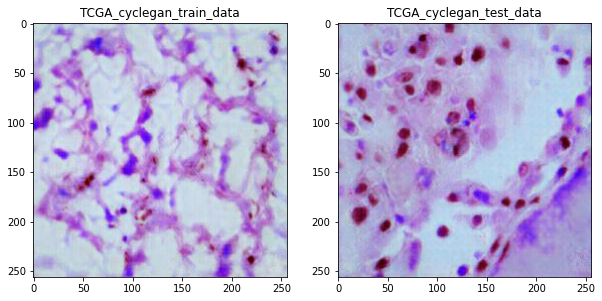

In [ ]:
# random show images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_cyclegan_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_cyclegan_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_cyclegan_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_cyclegan_test_data")
plt.imshow(img2)
plt.show

In [ ]:
#LC25000_train_data, LC25000_train_labels, TCGA_cyclegan_train_data, TCGA_cyclegan_train_labels

# Domain Adaptation

## Build Model

### Feature Extractor - ResNet50V2

In [ ]:
resnet50 = ResNet50(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="avg")

first_layer = resnet50.get_layer('conv5_block2_out')
inputs = Input(first_layer.output_shape[1:])

for layer in resnet50.layers[resnet50.layers.index(first_layer)+1:]:
    if layer.name == "conv5_block3_1_conv":
        x = layer(inputs)
    elif layer.name == "conv5_block3_add":  # change name
        x = layer([inputs, x])
    else:
        if layer.name == "conv5_block3_preact_bn":
            pass
        else:
            x = layer(x)

first_blocks = Model(resnet50.input, first_layer.output)
last_block = Model(inputs, x)

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
def load_resnet50(path="./Model/DANN_Model/resnet50_last_block_256.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/resnet50_last_block_256.hdf5")

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 8, 8, 2048)  0           []                               
                                ]                                                                 
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 8, 8, 512)    1049088     ['input_2[0][0]']                
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 8, 8, 512)   2048        ['conv5_block3_1_conv[1][0]']    
 ization)                                                                                         
                                                                                            

### Extract the features 

In [ ]:
LC25000_train_data_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data)))
TCGA_cyclegan_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_cyclegan_train_data)))

# one = OneHotEncoder(sparse=False)
# one.fit(np.array(LC25000_train_labels).reshape(-1, 1))

# LC25000_train_lab = one.transform(np.array(LC25000_train_labels).reshape(-1, 1))
# TCGA_cyclegan_train_lab = one.transform(np.array(TCGA_cyclegan_train_labels).reshape(-1, 1))

print("LC25000_train_data (source) shape: %s"%str(LC25000_train_data.shape))
print("TCGA_cyclegan_train_data (target) shape: %s"%str(TCGA_cyclegan_train_data.shape))

LC25000_train_data (source) shape: (3200, 256, 256, 3)
TCGA_cyclegan_train_data (target) shape: (3200, 256, 256, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
400/400 [==============================] - 5s 11ms/step - loss: 0.4296 - acc: 0.8616 - val_loss: 1.5163 - val_acc: 0.3781
Epoch 2/5
400/400 [==============================] - 3s 8ms/step - loss: 0.1335 - acc: 0.9522 - val_loss: 1.8498 - val_acc: 0.4038
Epoch 3/5
400/400 [==============================] - 3s 8ms/step - loss: 0.1010 - acc: 0.9638 - val_loss: 1.9327 - val_acc: 0.4369
Epoch 4/5
400/400 [==============================] - 3s 8ms/step - loss: 0.0926 - acc: 0.9688 - val_loss: 2.0746 - val_acc: 0.4178
Epoch 5/5
400/400 [==============================] - 3s 8ms/step - loss: 0.0932 - acc: 0.9697 - val_loss: 2.1442 - val_acc: 0.4244
Epoch 1/100
400/400 [==============================] - 7s 14ms/step - loss: 0.0853 - acc: 0.9725 - val_loss: 2.2899 - val_acc: 0.4350
Epoch 2/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0709 - acc: 0.9778 - val_loss: 2.6505 - val_acc: 0.4375
Epoch 3/100
400/400 [==============================] - 5s 12ms/step - loss: 

### Run 2

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
400/400 [==============================] - 7s 11ms/step - loss: 0.4025 - acc: 0.8684 - val_loss: 1.2787 - val_acc: 0.4247
Epoch 2/5
400/400 [==============================] - 4s 9ms/step - loss: 0.1232 - acc: 0.9556 - val_loss: 1.7880 - val_acc: 0.4003
Epoch 3/5
400/400 [==============================] - 3s 9ms/step - loss: 0.0978 - acc: 0.9672 - val_loss: 2.1878 - val_acc: 0.4056
Epoch 4/5
400/400 [==============================] - 3s 9ms/step - loss: 0.0929 - acc: 0.9628 - val_loss: 2.1272 - val_acc: 0.4316
Epoch 5/5
400/400 [==============================] - 3s 9ms/step - loss: 0.0856 - acc: 0.9694 - val_loss: 2.2273 - val_acc: 0.4269
Epoch 1/100
400/400 [==============================] - 8s 14ms/step - loss: 0.0724 - acc: 0.9750 - val_loss: 2.9847 - val_acc: 0.4181
Epoch 2/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0895 - acc: 0.9719 - val_loss: 2.4212 - val_acc: 0.4369
Epoch 3/100
400/400 [==============================] - 5s 12ms/step - loss: 

### Run 3

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
400/400 [==============================] - 6s 11ms/step - loss: 0.4332 - acc: 0.8584 - val_loss: 1.4956 - val_acc: 0.3922
Epoch 2/5
400/400 [==============================] - 4s 9ms/step - loss: 0.1241 - acc: 0.9538 - val_loss: 1.7851 - val_acc: 0.4034
Epoch 3/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0923 - acc: 0.9684 - val_loss: 2.2126 - val_acc: 0.4103
Epoch 4/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0861 - acc: 0.9659 - val_loss: 2.1328 - val_acc: 0.4219
Epoch 5/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0866 - acc: 0.9709 - val_loss: 2.5504 - val_acc: 0.4341
Epoch 1/100
400/400 [==============================] - 7s 14ms/step - loss: 0.0727 - acc: 0.9741 - val_loss: 2.7756 - val_acc: 0.4053
Epoch 2/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0734 - acc: 0.9756 - val_loss: 2.6992 - val_acc: 0.4194
Epoch 3/100
400/400 [==============================] - 5s 12ms/step - loss: 

### Run 4

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
400/400 [==============================] - 5s 11ms/step - loss: 0.4086 - acc: 0.8575 - val_loss: 1.4856 - val_acc: 0.3797
Epoch 2/5
400/400 [==============================] - 4s 9ms/step - loss: 0.1096 - acc: 0.9581 - val_loss: 1.8966 - val_acc: 0.4112
Epoch 3/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0986 - acc: 0.9631 - val_loss: 1.9672 - val_acc: 0.4087
Epoch 4/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0865 - acc: 0.9681 - val_loss: 2.3182 - val_acc: 0.4278
Epoch 5/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0932 - acc: 0.9669 - val_loss: 1.9832 - val_acc: 0.4375
Epoch 1/100
400/400 [==============================] - 7s 14ms/step - loss: 0.0677 - acc: 0.9747 - val_loss: 2.2483 - val_acc: 0.4178
Epoch 2/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0580 - acc: 0.9778 - val_loss: 2.4455 - val_acc: 0.4241
Epoch 3/100
400/400 [==============================] - 5s 12ms/step - loss: 

### Run 5

In [ ]:
lr = 0.5e-5
momentum = 0.9
alpha = 0.0002

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha), momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_resnet50(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_ex, LC25000_train_lab, epochs=100, batch_size=8, validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/5
400/400 [==============================] - 6s 11ms/step - loss: 0.4207 - acc: 0.8575 - val_loss: 1.4621 - val_acc: 0.4097
Epoch 2/5
400/400 [==============================] - 3s 9ms/step - loss: 0.1262 - acc: 0.9541 - val_loss: 1.8950 - val_acc: 0.4169
Epoch 3/5
400/400 [==============================] - 3s 9ms/step - loss: 0.0929 - acc: 0.9669 - val_loss: 2.4909 - val_acc: 0.3963
Epoch 4/5
400/400 [==============================] - 4s 9ms/step - loss: 0.0914 - acc: 0.9678 - val_loss: 2.4639 - val_acc: 0.4147
Epoch 5/5
400/400 [==============================] - 3s 9ms/step - loss: 0.0827 - acc: 0.9737 - val_loss: 2.3448 - val_acc: 0.4266
Epoch 1/100
400/400 [==============================] - 7s 14ms/step - loss: 0.0750 - acc: 0.9728 - val_loss: 2.6337 - val_acc: 0.4187
Epoch 2/100
400/400 [==============================] - 5s 12ms/step - loss: 0.0548 - acc: 0.9800 - val_loss: 3.0499 - val_acc: 0.4112
Epoch 3/100
400/400 [==============================] - 5s 12ms/step - loss: 

### Result

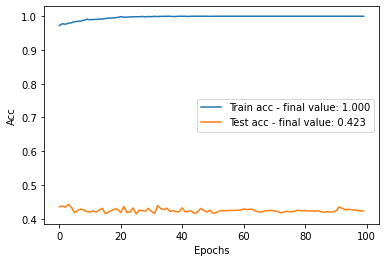

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


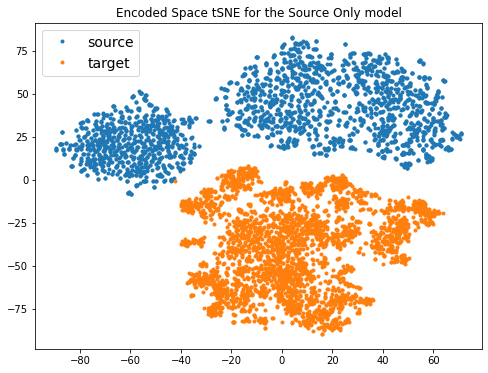

In [ ]:
LC25000_train_data_enc = finetunig.transform(LC25000_train_data_ex)
TCGA_cyclegan_train_data_enc = finetunig.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_cyclegan_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000
mean,0.008259,0.997269,7.371292,0.424209
std,0.017681,0.005826,1.896615,0.005320
min,0.000001,0.972500,2.289919,0.414062
25%,0.000008,0.998438,6.409636,0.420312
50%,0.000125,1.000000,8.292089,0.423438
75%,0.005087,1.000000,8.799259,0.426641
max,0.085320,1.000000,9.236657,0.442187


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_source_Resnet_256_RMS_0.5e-5_cyclegan.csv")

# Fit with adaptation

### Run 1

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1e-5,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/100
400/400 [==============================] - 12s 23ms/step - loss: 0.4277 - acc: 0.8622 - disc_loss: 0.3777 - val_loss: 1.4060 - val_acc: 0.4359
Epoch 2/100
400/400 [==============================] - 8s 20ms/step - loss: 0.1067 - acc: 0.9588 - disc_loss: 0.2211 - val_loss: 1.6630 - val_acc: 0.4378
Epoch 3/100
400/400 [==============================] - 8s 20ms/step - loss: 0.0948 - acc: 0.9659 - disc_loss: 0.1578 - val_loss: 1.7103 - val_acc: 0.4147
Epoch 4/100
400/400 [==============================] - 8s 20ms/step - loss: 0.0829 - acc: 0.9684 - disc_loss: 0.1111 - val_loss: 1.7398 - val_acc: 0.4272
Epoch 5/100
400/400 [==============================] - 8s 20ms/step - loss: 0.0799 - acc: 0.9712 - disc_loss: 0.0893 - val_loss: 1.8690 - val_acc: 0.4241
Epoch 6/100
400/400 [==============================] - 8s 20ms/step - loss: 0.0693 - acc: 0.9750 - disc_loss: 0.0791 - val_loss: 1.8168 - val_acc: 0.4244
Epoch 7/100
400/400 [==============================] - 8s 20ms/step - loss:

### Run 2

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1e-5,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/100
400/400 [==============================] - 16s 25ms/step - loss: 0.4278 - acc: 0.8622 - disc_loss: 0.3777 - val_loss: 1.4018 - val_acc: 0.4347
Epoch 2/100
400/400 [==============================] - 9s 22ms/step - loss: 0.1068 - acc: 0.9578 - disc_loss: 0.2232 - val_loss: 1.6637 - val_acc: 0.4381
Epoch 3/100
400/400 [==============================] - 9s 22ms/step - loss: 0.0946 - acc: 0.9659 - disc_loss: 0.1603 - val_loss: 1.7248 - val_acc: 0.4125
Epoch 4/100
400/400 [==============================] - 9s 22ms/step - loss: 0.0840 - acc: 0.9703 - disc_loss: 0.1119 - val_loss: 1.7278 - val_acc: 0.4212
Epoch 5/100
400/400 [==============================] - 9s 22ms/step - loss: 0.0795 - acc: 0.9719 - disc_loss: 0.0904 - val_loss: 1.8731 - val_acc: 0.4222
Epoch 6/100
400/400 [==============================] - 9s 22ms/step - loss: 0.0687 - acc: 0.9756 - disc_loss: 0.0805 - val_loss: 1.7970 - val_acc: 0.4206
Epoch 7/100
400/400 [==============================] - 9s 22ms/step - loss:

### Run 3

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1e-5,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/100
400/400 [==============================] - 13s 23ms/step - loss: 0.0443 - acc: 0.9934 - disc_loss: 2.4088 - val_loss: 14.4204 - val_acc: 0.4975
Epoch 2/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0739 - acc: 0.9875 - disc_loss: 5.2505 - val_loss: 22.8079 - val_acc: 0.4922
Epoch 3/100
400/400 [==============================] - 9s 22ms/step - loss: 0.0586 - acc: 0.9891 - disc_loss: 15.7453 - val_loss: 23.4182 - val_acc: 0.4947
Epoch 4/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0489 - acc: 0.9903 - disc_loss: 15.7513 - val_loss: 26.0122 - val_acc: 0.4956
Epoch 5/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0578 - acc: 0.9897 - disc_loss: 15.7764 - val_loss: 22.5648 - val_acc: 0.4925
Epoch 6/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0571 - acc: 0.9916 - disc_loss: 15.8329 - val_loss: 36.3673 - val_acc: 0.4997
Epoch 7/100
400/400 [==============================] - 9s 21ms/st

### Run 4

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1e-5,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/100
400/400 [==============================] - 13s 23ms/step - loss: 0.4278 - acc: 0.8612 - disc_loss: 0.3783 - val_loss: 1.4022 - val_acc: 0.4363
Epoch 2/100
400/400 [==============================] - 9s 21ms/step - loss: 0.1067 - acc: 0.9588 - disc_loss: 0.2238 - val_loss: 1.6752 - val_acc: 0.4394
Epoch 3/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0946 - acc: 0.9650 - disc_loss: 0.1614 - val_loss: 1.7126 - val_acc: 0.4156
Epoch 4/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0834 - acc: 0.9697 - disc_loss: 0.1106 - val_loss: 1.7397 - val_acc: 0.4216
Epoch 5/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0794 - acc: 0.9709 - disc_loss: 0.0899 - val_loss: 1.8854 - val_acc: 0.4219
Epoch 6/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0697 - acc: 0.9747 - disc_loss: 0.0801 - val_loss: 1.7971 - val_acc: 0.4212
Epoch 7/100
400/400 [==============================] - 9s 21ms/step - loss:

### Run 5

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 0.5e-5
momentum = 0.9
alpha = 0.0002


encoder = load_resnet50()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),  momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),  momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1e-5,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_cyclegan_train_data_ex, epochs=100, batch_size=8,  validation_data=(TCGA_cyclegan_train_data_ex, TCGA_cyclegan_train_lab))

Epoch 1/100
400/400 [==============================] - 13s 23ms/step - loss: 0.4278 - acc: 0.8619 - disc_loss: 0.3783 - val_loss: 1.4021 - val_acc: 0.4350
Epoch 2/100
400/400 [==============================] - 9s 21ms/step - loss: 0.1066 - acc: 0.9581 - disc_loss: 0.2237 - val_loss: 1.6697 - val_acc: 0.4381
Epoch 3/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0943 - acc: 0.9656 - disc_loss: 0.1608 - val_loss: 1.7165 - val_acc: 0.4128
Epoch 4/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0842 - acc: 0.9691 - disc_loss: 0.1113 - val_loss: 1.7379 - val_acc: 0.4234
Epoch 5/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0796 - acc: 0.9712 - disc_loss: 0.0926 - val_loss: 1.8668 - val_acc: 0.4225
Epoch 6/100
400/400 [==============================] - 9s 21ms/step - loss: 0.0691 - acc: 0.9750 - disc_loss: 0.0795 - val_loss: 1.7893 - val_acc: 0.4250
Epoch 7/100
400/400 [==============================] - 9s 21ms/step - loss:

### Result

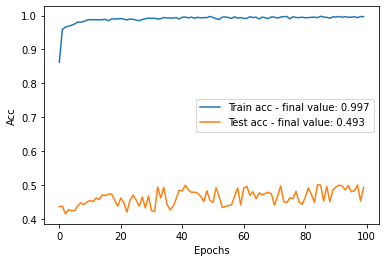

In [ ]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


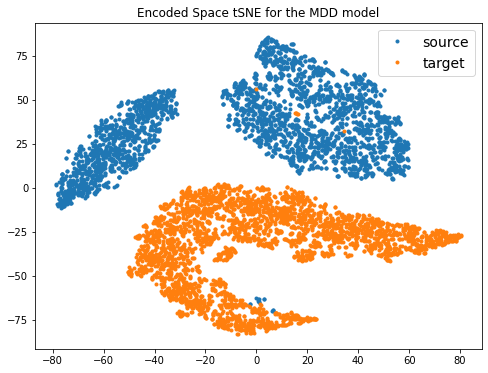

In [ ]:
LC25000_train_data_enc = mdd.transform(LC25000_train_data_ex)
TCGA_train_data_enc = mdd.transform(TCGA_cyclegan_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_ex), 0], X_tsne[:len(LC25000_train_data_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_ex):, 0], X_tsne[len(LC25000_train_data_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,100.000000,100.000000,100.000000,100.000000,100.000000
mean,0.034490,0.989769,0.054161,5.080564,0.463259
std,0.042982,0.014465,0.138655,2.463354,0.022742
min,0.008314,0.862188,0.000029,1.406022,0.414688
25%,0.020075,0.989609,0.000333,3.448111,0.447344
50%,0.026563,0.992969,0.002000,4.434373,0.462812
75%,0.036733,0.995000,0.025580,6.134048,0.481562
max,0.427664,0.997813,0.920051,11.826160,0.500938


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_256/MDD_Resnet_256_RMS_0.51e-5_g1-5_cyclegan.csv")

In [ ]:
import gc
gc.collect()

6787